> 假设要解决一个复杂的问题，让众多学生去回答，然后汇总他们的答案。在许多情况下，会发现这个汇总的答案比一个老师的答案要好。同样，如果汇总了一组预测变量（例如分类器或回归因子）的预测结果，则通常会得到比最佳个体预测变量得到更好的预测结果。这种技术被称为集成学习（Ensemble Learning）。

集成学习主要分成以下5种：
* 投票分类器：不同算法分类器的集成
* bagging&pasting：同一算法随机样本分类器的集成
* random patches&random subspaces：同一算法随机特征样本分类器的集成
* boosting：
* stacking：

# 投票分类器(voting classifier)
* 有两种形式：硬投票和软投票
* 两者的区别在于：
    * 硬投票基于弱分类器(weak learner)的预测结果计算得到最多选票的类。
    * 软投票基于弱分类器的预测概率计算平均概率，预测最高概率的类。

## 硬投票分类(hard voting)
* 创建集成分类器的最简单方法是聚合多个分类器（如Linear，Logistic，SVM，k-近邻、Ramdomforest等）的预测结果并计算得到最多选票的类，这就是硬投票分类器。
* 硬投票分类器通常比集合中最好的分类器实现更高的准确性，比如每个学习器能到达51%的精度，1000个这样的分类器，通过投票取最大的分类，则能达到接近75%的精度。分类器越多精度更高。
* 需要注意的是：每个弱分类器需要完全独立，相似的分类器很可能会犯同样的错误，所以会有大部分错误的选票，从而降低集体的准确性。因此，需要使用非常不同的算法来训练。

In [24]:
# 集成Logistic回归，SVM分类，Random forest分类的硬投票

import warnings
warnings.filterwarnings('ignore')

#产生moon数据并分开训练测试集
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
(X,y)=make_moons(1000,noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#构造模型和集成模型
from sklearn.ensemble import RandomForestClassifier #随机森林
from sklearn.ensemble import VotingClassifier # 投票分类器
from sklearn.linear_model import LogisticRegression # 逻辑回归
from sklearn.svm import SVC # 支持向量机

# 构建弱分类器
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

# 构建硬投票
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard') #voting选择hard
voting_clf.fit(X_train, y_train)

#训练并预测
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.805
RandomForestClassifier 0.765
SVC 0.83
VotingClassifier 0.825


* 可以看到集成的投票分类器的正确率比其中最好的分类器要高。

## 软投票(soft voting)
* 如果所有分类器都能够估计分为每一类的概率，即都有predict_proba()方法，那么可以对每个分类器的概率取平均，再预测具有最高类概率的类，这被称为软投票(soft voting)。它通常比硬投票(hard voting)取得更好的效果，因为它给予了高度信任的投票更多的权重。
* 默认情况下SVC没有predict_proba()方法，所以需要将它的probability参数设置为True（这将使SVC使用交叉验证来估计类概率，减慢训练速度，并且会增加predict_proba（）方法）

In [30]:
# 集成Logistic回归，SVM分类，Random forest分类的软投票
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 构建弱分类器
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)# 修改SVC类使其有predict_proba()方法

# 构建软投票
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='soft')
voting_clf.fit(X_train, y_train)

#训练并预测
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.805
RandomForestClassifier 0.765
SVC 0.83
VotingClassifier 0.81


# bagging & pasting
* 投票分类器获得多种分类器的方式是使用不同的训练算法。另一种方法是对每个分类器使用相同的算法，但是要在训练集的不同随机子集上进行训练。与投票分类器一样，最后结果预测为被预测最多的类（分类问题）或平均值（回归问题）。
* 一般来说，相比在完整的训练数据上得到的结果，集成学习得到的结果具有类似的偏差和较低的方差。而且这种算法具有并行性。
* 如果抽样时有放回，称为Bagging；当抽样没有放回，称为Pasting。相比pasting算法，bagging算法偏差会稍微高一些，但是方差更小，通常能取得不错的效果，所以通常情况下人们更愿意用bagging算法。

In [31]:
# 使用bagging算法训练模型，选择决策树分类器作为训练算法
from sklearn.ensemble import BaggingClassifier # 导入bagging集成
from sklearn.tree import DecisionTreeClassifier # 导入决策树

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.815


* 参数解读：
    * n_estimators表示产生分类器的数目；
    * max_samples为每个分类器分得的样本数；
    * bootstrap=True表示使用bagging算法，否则为pasting算法；
    * n_jobs表示使用CPU核的数目，-1代表把能用的都用上。

## Out-of-Bag Evaluation

* 由于bagging算法采用有放回的抽样方式（自助采样法），假设训练集有m个样本，每次抽取一个后放回，直到抽到m个样本，那么样本始终没有被抽到的概率为${(1-\frac{1}{m})}^m$,取极限得：$$\lim_{m->∞}{(1-\frac{1}{m})}^m = \frac{1}{e} ≈ 0.368$$
* 这意味对于每一个分类器大约有36.8%的样本没有用于训练，这样的样本成为Out-of-Bag。
* 所以可以使用这些样本得到结果的平均值来用于验证模型，而不需要划分训练验证集或交叉验证。在Scikit-learn中只需要设置参数oob_score=True即可使用这种方法估计。

In [32]:
# 设置oob_score=True
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
print("oob", bag_clf.oob_score_)

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print("test", accuracy_score(y_test, y_pred))

oob 0.775
test 0.785


* 可以看到两个精度还是比较相似的，因此可以用与模型的验证。

# random patches & random subspaces
* 除了能随机选样本创建多个子分类器以外还能够随机选择特征来创建多个子分类器，通过参数max_features和bootstrap_features实现，其含义与max_samples和bootstrap类似。
* 对特征进行采样能够提升模型的多样性，增加偏差，减少方差。
* 当处理高维(多特征)数据（例如图像）时，这种方法比较有用。同时对训练数据和特征进行抽样称为Random Patches，只针对特征抽样而不针对训练数据抽样是Random Subspaces。

## 随机森林
* 随机森林就是典型的Random Patches，是以决策树算法为基础，通过bagging算法采样训练样本，再随机抽取特征，最终选择最优特征划分的算法。
* 随机森林对应sklearn中的RandomForestClassifier / RandomForestRegression，它有决策数的所有参数，以及bagging的所有参数。

In [33]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print("random forest", accuracy_score(y_test, y_pred_rf))

random forest 0.815


## 超随机树
* 随机森林算法每个分类器是从随机抽样部分特征，然后选择最优特征来划分的，而超随机树(Extremely Randomized Trees)使用随机的阈值分割这个最优特征，而不是最优的阈值，可以增加偏差，减少方差。
* 一般来说，Extra-Trees训练速度优于随机森林，因为寻找最优的阈值比随机阈值耗时。不过，两者哪个好不好比较，需要通过交叉验证得到结果。
* 超随机数对应sklearn的类ExtraTreesClassifier \ ExtraTreesRegressor，参数与随机森林相同。

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

ET_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ET_clf.fit(X_train, y_train)

y_pred_et = ET_clf.predict(X_test)
print("Extra-Trees", accuracy_score(y_test, y_pred_et))

Extra-Trees 0.815


## 特征重要性
* 由于决策树算法根据最优特征分层划分的，即根部的特征更为重要，而底部的特征不重要（不出现的特征更不重要）。根据这个可以判断特征的重要程度。
* Sklearn可以通过feature_importance获得特征的重要程度。

In [38]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.093893900697214
sepal width (cm) 0.021823507438293772
petal length (cm) 0.4185569314270119
petal width (cm) 0.46572566043748037


* 可以看到petal length和petal width的重要性较高，为47%和42%。

* 随机森林还能对图像中像素（特征）的重要程度，下面以MNIST图像为例子。

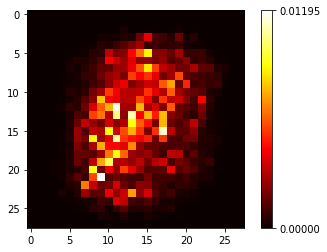

In [50]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('mnist-original',data_home='datasets')

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])
importances = rnd_clf.feature_importances_.reshape(28, 28)

# 画个图像出来看看
plt.imshow(importances, cmap = matplotlib.cm.hot)
plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
plt.show()

# Boosting
* Boosting主要思想是按顺序训练学习器，以尝试修改之前的学习器。Boosting的方法有许多，最为有名的方法为AdaBoost（Adaptive Boosting）和Gradient Boosting。

## Adaboost
* Adaboost是二分类学习器，如果要多分类，则可以设置参数algorithm=”SAMME”,如果需要predict_proba()方法，则设置参数algorithm=”SAMME.R”。AdaBoost如果产生过拟合可以减少学习器的数目(n_estimator)。
* SVM算法由于训练速度慢且不稳定，所以不适合AdaBoost算法。
* AdaBoost的缺点为不能并行，因为每一个学习器依赖上一个学习器。

* Adaboost的工作流程：\
1）假设有m个训练样本，初始化每个样本的权值$w^{(i)}$为$\frac{1}{m}$，经过第j个学习器训练以后，计算训练样本加权错误率$r_j$。\
2）然后计算每个学习器对应的权值$\alpha$。（如下图）当比较小时，说明该学习器的准确率越高，分配的权值也越大。$$\alpha_j = \eta log\frac{1-r_j}{r_j}$$其中$\eta$为学习
率（和梯度下降法有点相似）。
3）更新样本权值$w^{(i)}$，将没有预测出来的样本权值变大，以便后续的学习器重点训练。$$ w^{(i)} = w^{(i)}\qquad \widehat{y}_j^{(i)} = y_j^{(i)}$$
$$w^{(i)} = w^{(i)}exp(\alpha_j)\qquad \widehat{y}_j^{(i)} ≠ y_j^{(i)}$$
4）重复（1）（2）（3）步骤不断更新权值和训练新的学习器，直到学习器到一定的数目。
5）最终得到N个学习器，计算每个学习器对样本的加权和，并预测为加权后最大的一类。
$$\widehat{y}(x)= argmax {\sum_{{j=1}\\ {\widehat{y}(x) = k}}^N}{\alpha_j} $$

In [53]:
# 以决策树为基学习器的Adaboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)
ada_clf.predict_proba(X_test)[0]

array([0.48268585, 0.51731415])

## Gradient Boosting
* 和AdaBoost类似，Gradient Boosting也是逐个训练学习器，尝试纠正前面学习器的错误。
* 不同的是，AdaBoost纠正错误的方法是更加关注前面学习器分错的样本，Gradient Boosting（适合回归任务）纠正错误的方法是拟合前面学习器的残差（预测值减真实值）。

In [93]:
# 我们来看一下Gradient Boosting的实现原理
import numpy as np
import numpy.random as rnd
from sklearn.tree import DecisionTreeRegressor

#准备数据
X = rnd.rand(200, 1) - 1
y = 3*X**2 + 0.05 * rnd.randn(200,1) #加入了二次和噪声数据

#训练第一个模型
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

#根据上一个模型的残差训练第二个模型
y2 = y - tree_reg1.predict(X).reshape(200,1)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

#再根据上一个模型的残差训练第三个模型
y3 = y2 - tree_reg2.predict(X).reshape(200,1)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

#预测
X_new=np.array([[0.5]])
y_pred = np.sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.03072022])

* 对应Sklearn中的函数为GradientBoostingRegressor（决策树为基）。

In [94]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)
gbrt.predict(X_new)

array([0.03072022])

* 可以看到输出预测值和上面一样。

* 参数learning_rate表示每个学习器的贡献程度，如果设置learning_rate比较低，则需要较多的学习器拟合训练数据，但是通常会得到更好的效果。
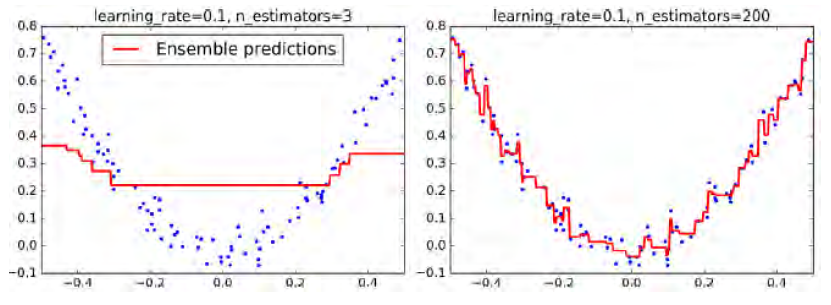
* 为了找到最优学习器的数量，可以使用early stopping方法。对应可以使用staged_predict()方法，该方法能够返回每增加一个学习器的预测结果。

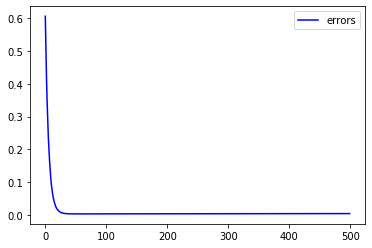

In [118]:
# staged_predict()可以训练完最大数目的学习器再找最小错误的
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=500)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

# 画图看一下
n_estimators=np.arange(500)
plt.plot(n_estimators,errors,'b-',label='errors')
plt.legend()
plt.show()

* 从图上可知，刚开始随着学习器的增加，误差下降速度飞快。到达一定阈值之后，误差下降不明显，且有稍微回升的趋势。

In [122]:
# 也可以使用for循环寻找最优学习器(warm_start = True)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=1,
                                 learning_rate=0.1, random_state=42, 
                                warm_start = True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping
print(gbrt.n_estimators)

65


* GradientBoostingRegressor类可以通过设置参数subsample，来确定每棵树训练的样本比例，这如上面的bagging一样，可以获得较低的方差和高的偏差。但也大大加快训练速度。这种技术被称为Stochastic Gradient Boosting。

# stacking
* 把每个学习器得到的结果作为特征进行训练(Blend)，再预测出最后的结果，这就是Stacking的思想。
* 为了上述思想，需要将训练数据分为两部分。第1部分用于训练多个基学习器。第2部分（hold-out set）用于训练blender。blender的输入为第2部分数据在第一部分数据训练好的多个模型的预测结果。
* 实际上可以训练多个blender（如一个Logistic回归，另一个Ramdomforest）实现这个思想的诀窍是将训练集分成三份，第一份用于训练多个基学习器，第二份用于训练第二个层（使用第一个层的预测器进行的预测作为输入），第三份用于训练第三层（使用第二层的预测器进行的预测作为输入）。
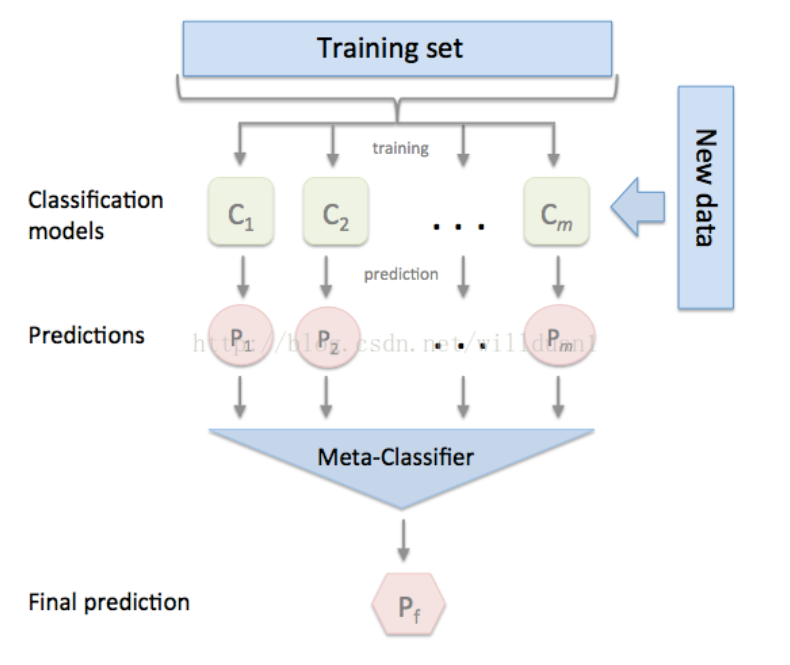

* 遗憾的是，sklearn没有提供stacking的实现，接下来我们使用mlxtend函数库来实现。
* mlxtend实现：from mlxtend.classifier import StackingClassifier

In [130]:
# 载入数据
from sklearn import datasets
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

# 使用xgboost、lightgbm、随机森林作为基分类器，逻辑回归为元分类器
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier # 导入堆叠分类器
import numpy as np

# 创建基分类器
basemodel1 = XGBClassifier()
basemodel2 = lgb.LGBMClassifier()
basemodel3 = RandomForestClassifier(random_state=1)

# 创建元分类器和堆叠分类器
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[basemodel1, basemodel2, basemodel3], 
                          meta_classifier=lr)
print('5-fold cross validation:\n')
for basemodel, label in zip([basemodel1, basemodel2, basemodel3, sclf], 
                            ['xgboost', 
                             'lightgbm', 
                             'Random Forest',
                             'StackingClassifier']):
    scores = model_selection.cross_val_score(basemodel,X, y, 
                                             cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.94 (+/- 0.06) [xgboost]
Accuracy: 0.95 (+/- 0.03) [lightgbm]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.94 (+/- 0.04) [StackingClassifier]
